In [87]:
import os
import csv

# Directory containing the files
directory = "namesbystate"

# Dictionary to store the data
data = {}

# List all files in the directory
files = os.listdir(directory)

# Filter out files that match the pattern "STATE.*.txt"
state_files = [f for f in files if f.startswith("STATE")]

# Read each state file
for state_file in state_files:
    state_abbr = state_file.split('.')[1]  # Extract state abbreviation from the filename
    
    # Initialize the state dictionary if not already present
    if state_abbr not in data:
        data[state_abbr] = {}
    
    with open(os.path.join(directory, state_file), 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            year = int(row[2])
            name_gender_key = f"{row[3]}_{row[1]}"
            
            # Initialize the year dictionary if not already present
            if year not in data[state_abbr]:
                data[state_abbr][year] = {}
            
            data[state_abbr][year][name_gender_key] = int(row[4])
# print(data["AZ"][1910]["Mary_F"])


In [77]:
from gensim import corpora
from collections import Counter

# Select the year of interest
year_of_interest = 2022

# Initialize the Counter for names
name_counter = Counter()

# Extract data for the specified year
for state, years in data.items():
    if year_of_interest in years:
        for name, count in years[year_of_interest].items():
            name_counter[name] += count  # Count the names

# Determine the top X most frequent names to remove
X = 0  # Set X as needed
names_to_remove = set(name for name, _ in name_counter.most_common(X))
print("removed set:", names_to_remove)
# Keep the next top Y names in the dictionary
Y = 1300  # Set Y as needed
names_to_keep = set(name for name, _ in name_counter.most_common(X + Y)) - names_to_remove

# Process the data for the year of interest, applying filtering and then normalization
common_total = 1000  # Common total for normalization
documents = []

for state, years in data.items():
    if year_of_interest in years:
        # Apply the filtering
        filtered_names = {name: count for name, count in years[year_of_interest].items() if name in names_to_keep}

        # Calculate the total count after filtering
        total_count = sum(filtered_names.values())

        # Calculate the scale factor for normalization
        scale_factor = common_total / total_count if total_count else 0

        # Scale and round the counts
        scaled_names = {name: round(count * scale_factor) for name, count in filtered_names.items()}

        # Create the document for the state
        document = [name for name, scaled_count in scaled_names.items() for _ in range(scaled_count)]
        documents.append(document)

# Create a dictionary from the data
dictionary = corpora.Dictionary(documents)

# Convert the documents to a bag-of-words representation
corpus = [dictionary.doc2bow(document) for document in documents]


removed set: set()


In [88]:
from gensim import corpora, models
from gensim.models import TfidfModel

# Extract 2022 data
documents = []
for state, years in data.items():
    for y in range(2022, 2023, 5):
        if y in years:
            names = []
            for name, count in years[y].items():
                names.extend([name] * count)
            documents.append(names)


# Create a dictionary from the data
dictionary = corpora.Dictionary(documents)
# Convert the documents to a bag-of-words representation
corpus = [dictionary.doc2bow(document) for document in documents]

In [89]:
from gensim import matutils

# Convert the corpus into a dense matrix
dense_corpus = matutils.corpus2dense(corpus, num_terms=len(dictionary)).T

# The resulting 'dense_corpus' is a NumPy array representing the bag-of-words matrix
print(dense_corpus.shape)

(51, 9790)


In [90]:
import matplotlib.pyplot as plt

def plot_bar_chart(data, labels=None, title="Bar Chart", xlabel="X-axis", ylabel="Y-axis"):
    """
    Plots a bar chart.

    :param data: List or array-like, the data to plot.
    :param labels: List of strings, the labels for each bar. Must be the same length as data.
    :param title: String, the title of the plot.
    :param xlabel: String, the label for the x-axis.
    :param ylabel: String, the label for the y-axis.
    """
    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Generate bar positions
    x_pos = range(len(data))

    # Plot data
    ax.bar(x_pos, data, align='center', alpha=0.7)

    # Add labels
    if labels is not None:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels)

    # Set other labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Show the plot
    plt.show()


import matplotlib.pyplot as plt

def plot_line_chart(data, labels=None, title="Line Chart", xlabel="X-axis", ylabel="Y-axis"):
    """
    Plots a line chart.

    :param data: List or array-like, the data to plot.
    :param labels: List of strings, the labels for each point on the x-axis.
    :param title: String, the title of the plot.
    :param xlabel: String, the label for the x-axis.
    :param ylabel: String, the label for the y-axis.
    """
    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Generate x positions
    x_pos = range(len(data))

    # Plot data
    ax.plot(x_pos, data, marker='o')  # 'o' is for circular markers

    # Add labels
    if labels is not None:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels)

    # Set other labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Optionally, add grid for easier reading
    ax.grid(True)

    # Show the plot
    plt.show()



In [101]:
import BNM

import importlib

example = importlib.reload(BNM)
LDAGibbsSampler = example.LDAGibbsSampler


K = 5
train_docs = dense_corpus.astype(int)

alpha = 0.3
eta = 0.1
gamma = 0.1

sampler = LDAGibbsSampler(K, train_docs, alpha, eta, gamma)
loss_array = sampler.sample(num_iterations=50)

Epoch 1, Training Log-Likelihood: -30248155.45149114
Epoch 2, Training Log-Likelihood: -30249644.908663634
Epoch 3, Training Log-Likelihood: -30249988.59066986
Epoch 4, Training Log-Likelihood: -30247813.62560904
Epoch 5, Training Log-Likelihood: -30247652.964978542
Epoch 6, Training Log-Likelihood: -30247548.67053171
Epoch 7, Training Log-Likelihood: -30246254.087688748
Epoch 8, Training Log-Likelihood: -30245704.721175436
Epoch 9, Training Log-Likelihood: -30244861.48806696
Epoch 10, Training Log-Likelihood: -30245077.895995505
Epoch 11, Training Log-Likelihood: -30244738.043281857
Epoch 12, Training Log-Likelihood: -30244377.39099786
Epoch 13, Training Log-Likelihood: -30244047.890820615
Epoch 14, Training Log-Likelihood: -30243889.831922643
Epoch 15, Training Log-Likelihood: -30243632.647150755
Epoch 16, Training Log-Likelihood: -30243422.614070613
Epoch 17, Training Log-Likelihood: -30243586.037388485
Epoch 18, Training Log-Likelihood: -30243262.795971107
Epoch 19, Training Log-Li

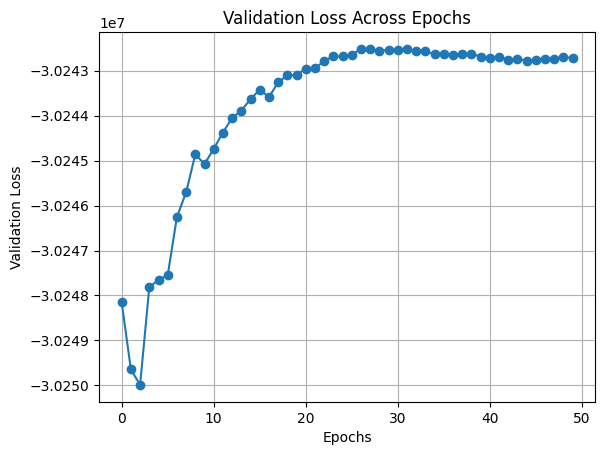

In [102]:
plot_line_chart(loss_array[:500], title="Validation Loss Across Epochs", xlabel="Epochs", ylabel="Validation Loss")

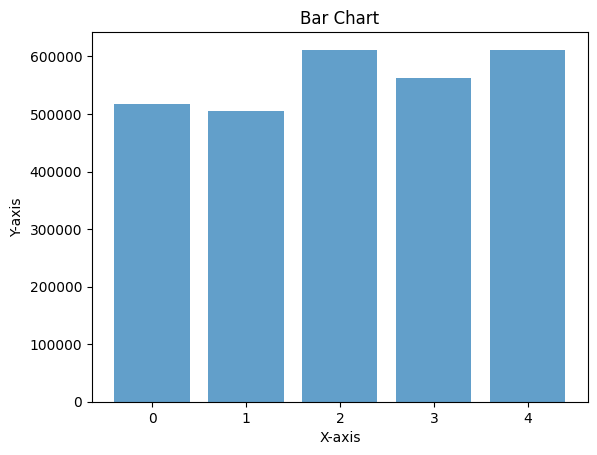

In [103]:
plot_bar_chart(sampler.topic_count)

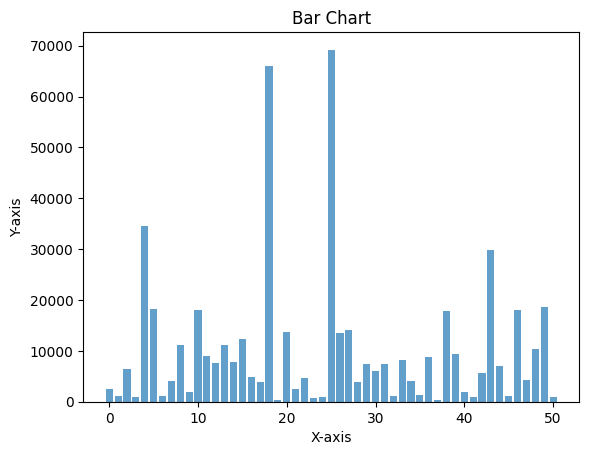

In [104]:
plot_bar_chart(sampler.topic_document_count[0])

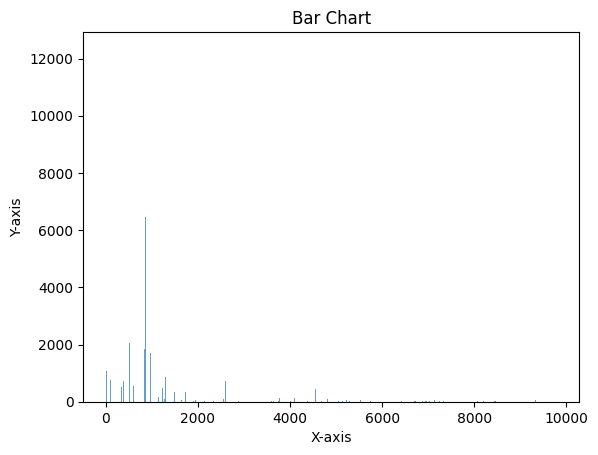

In [105]:
plot_bar_chart(sampler.topic_word_count[2])

In [106]:
def get_document_topic_distributions(self):
        """
        Returns the topic distribution for each document.
        """
        # Normalize the topic-document count by the sum across topics for each document
        normalized = self.topic_document_count / self.topic_document_count.sum(axis=0)
        
        # normalized = self.best_model_state['topic_document_count'] / self.best_model_state['topic_document_count'].sum(axis=0)
        return normalized.T  # Transpose so that rows correspond to documents
doc_topic_distributions = get_document_topic_distributions(sampler)

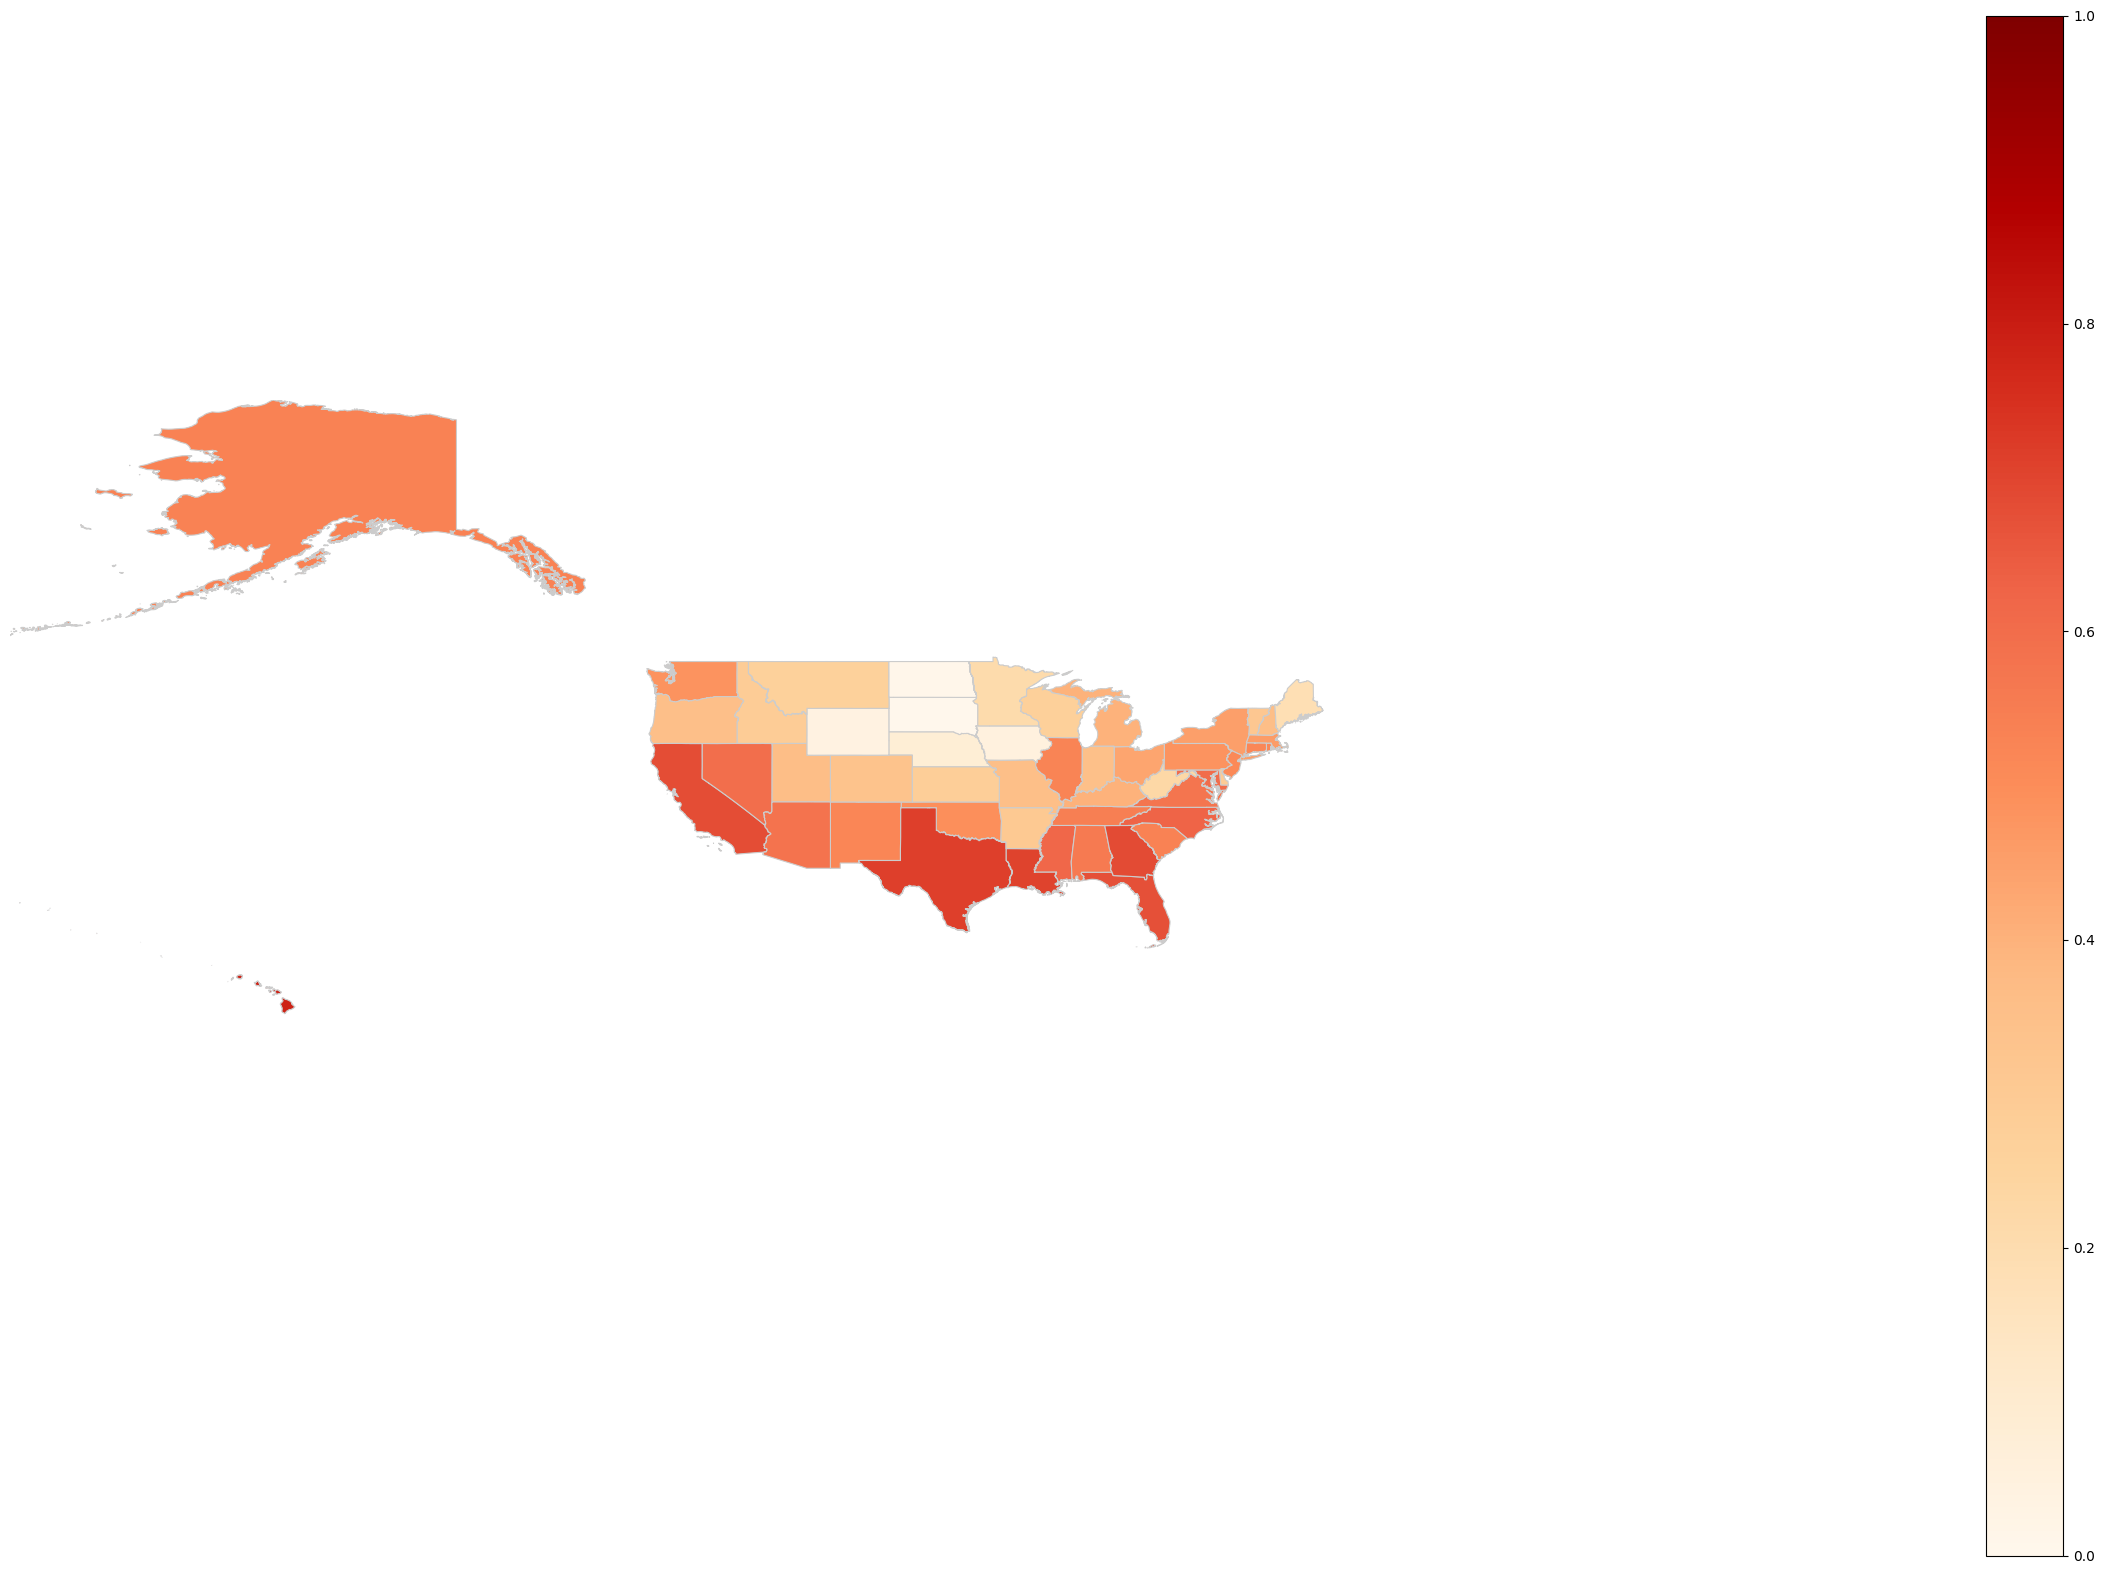

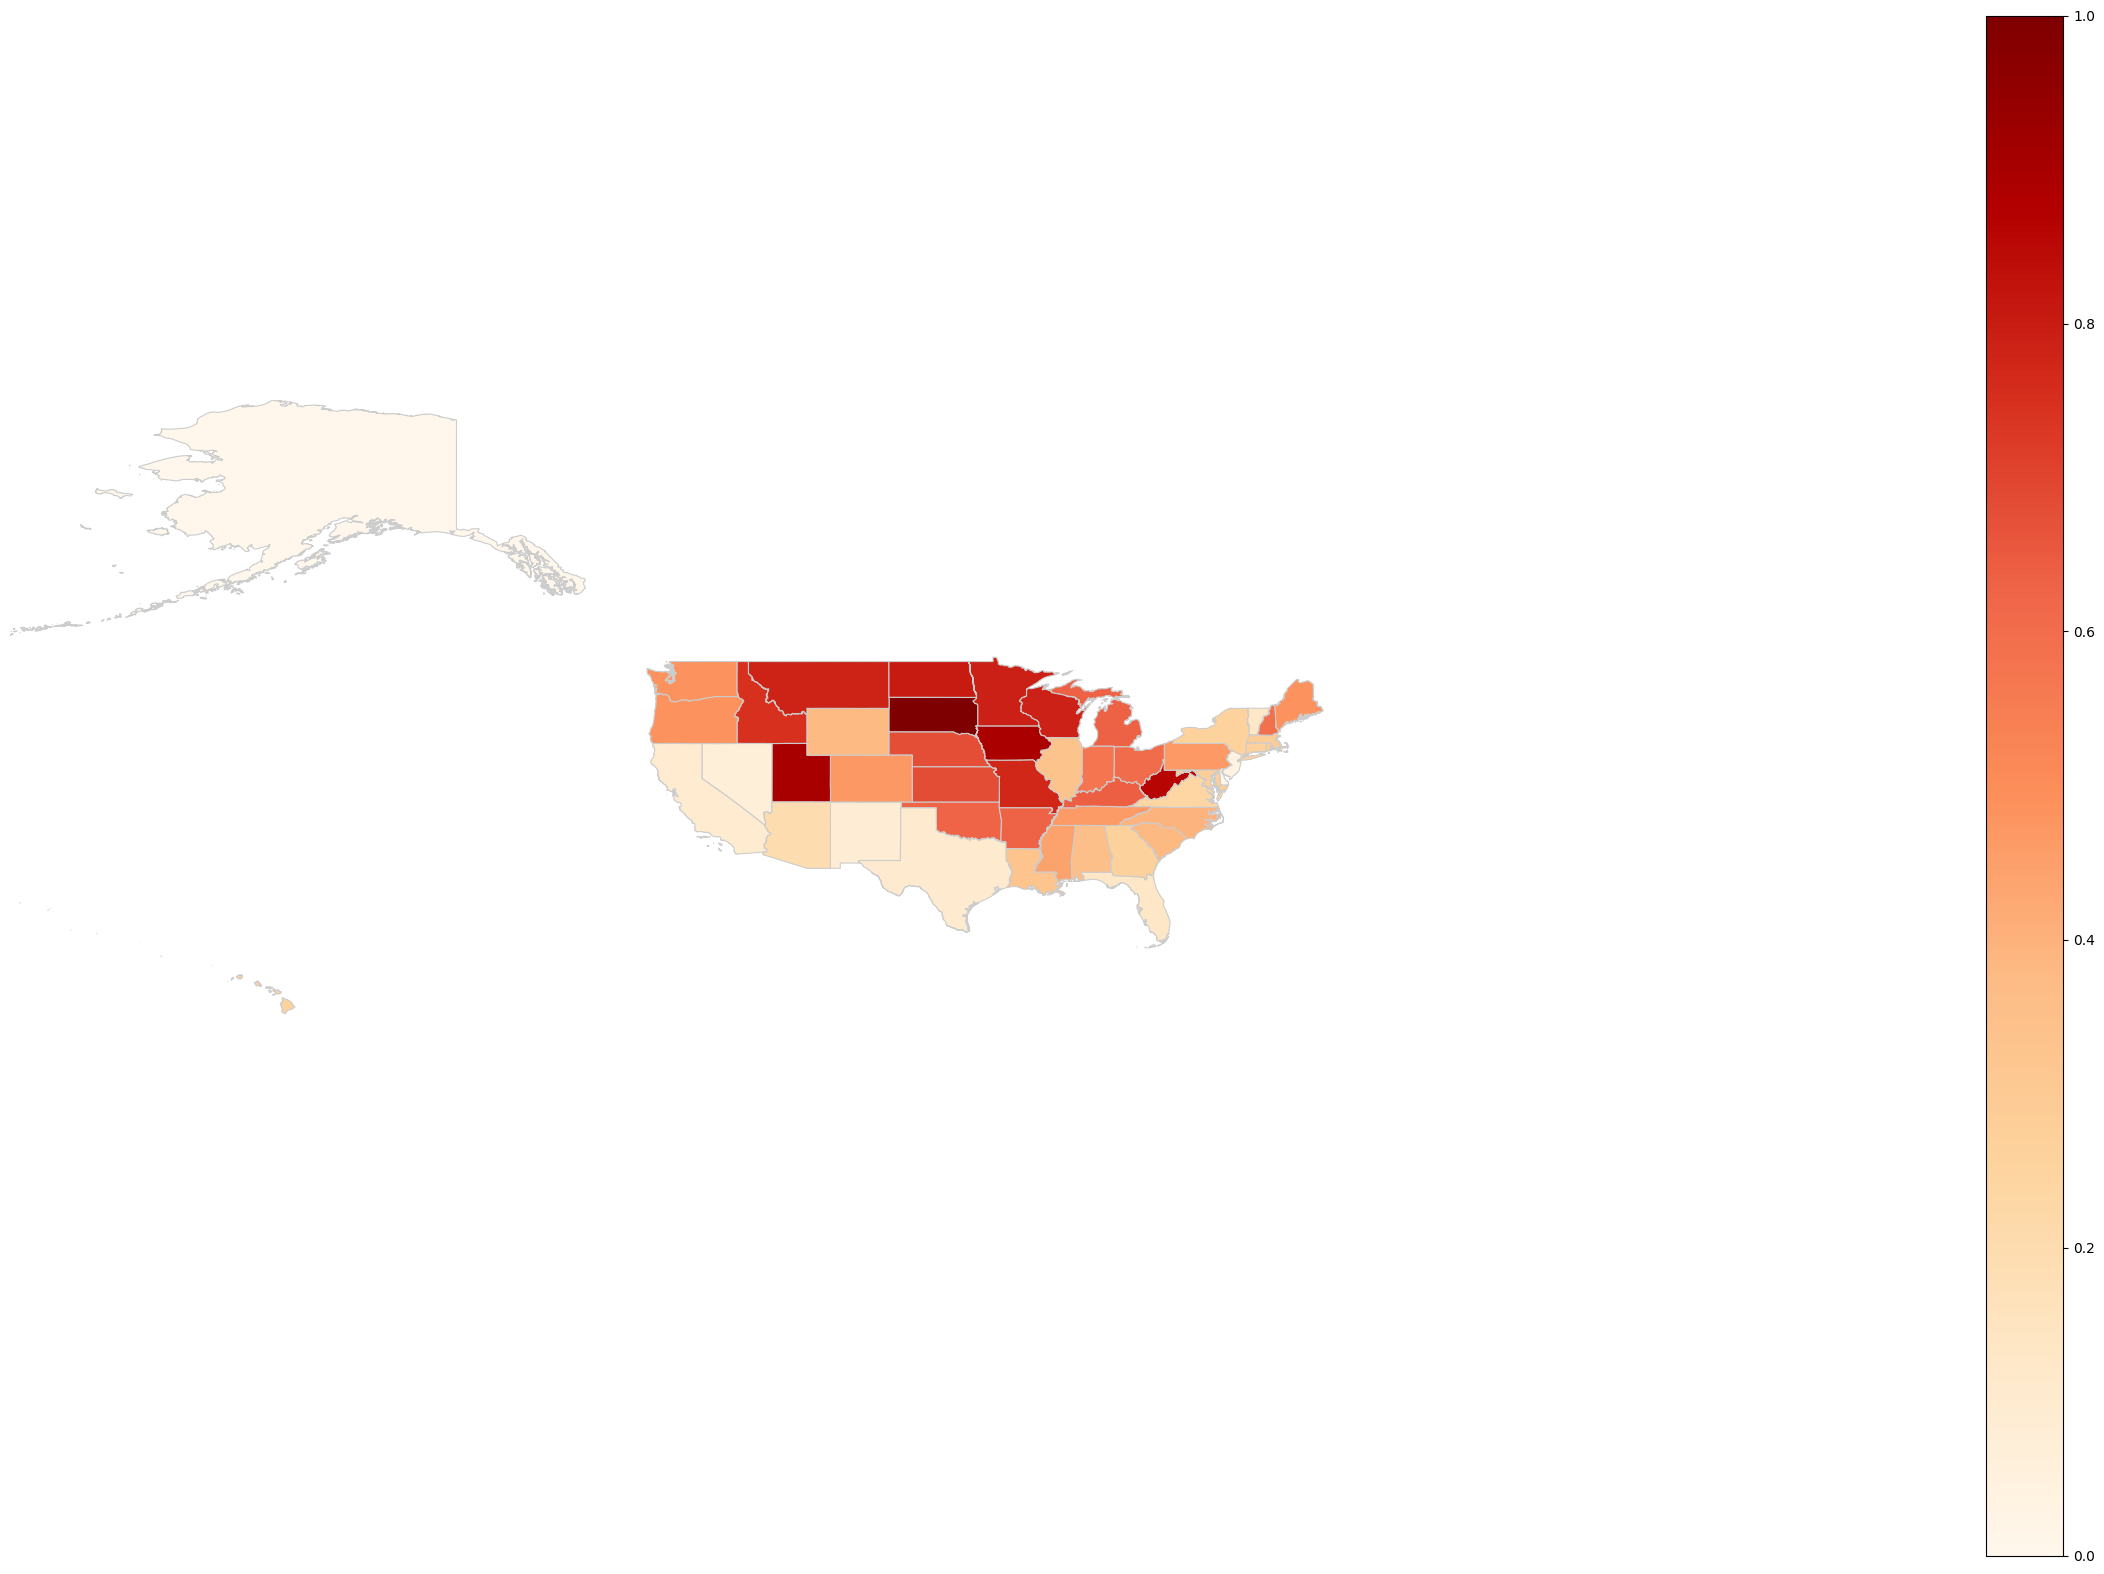

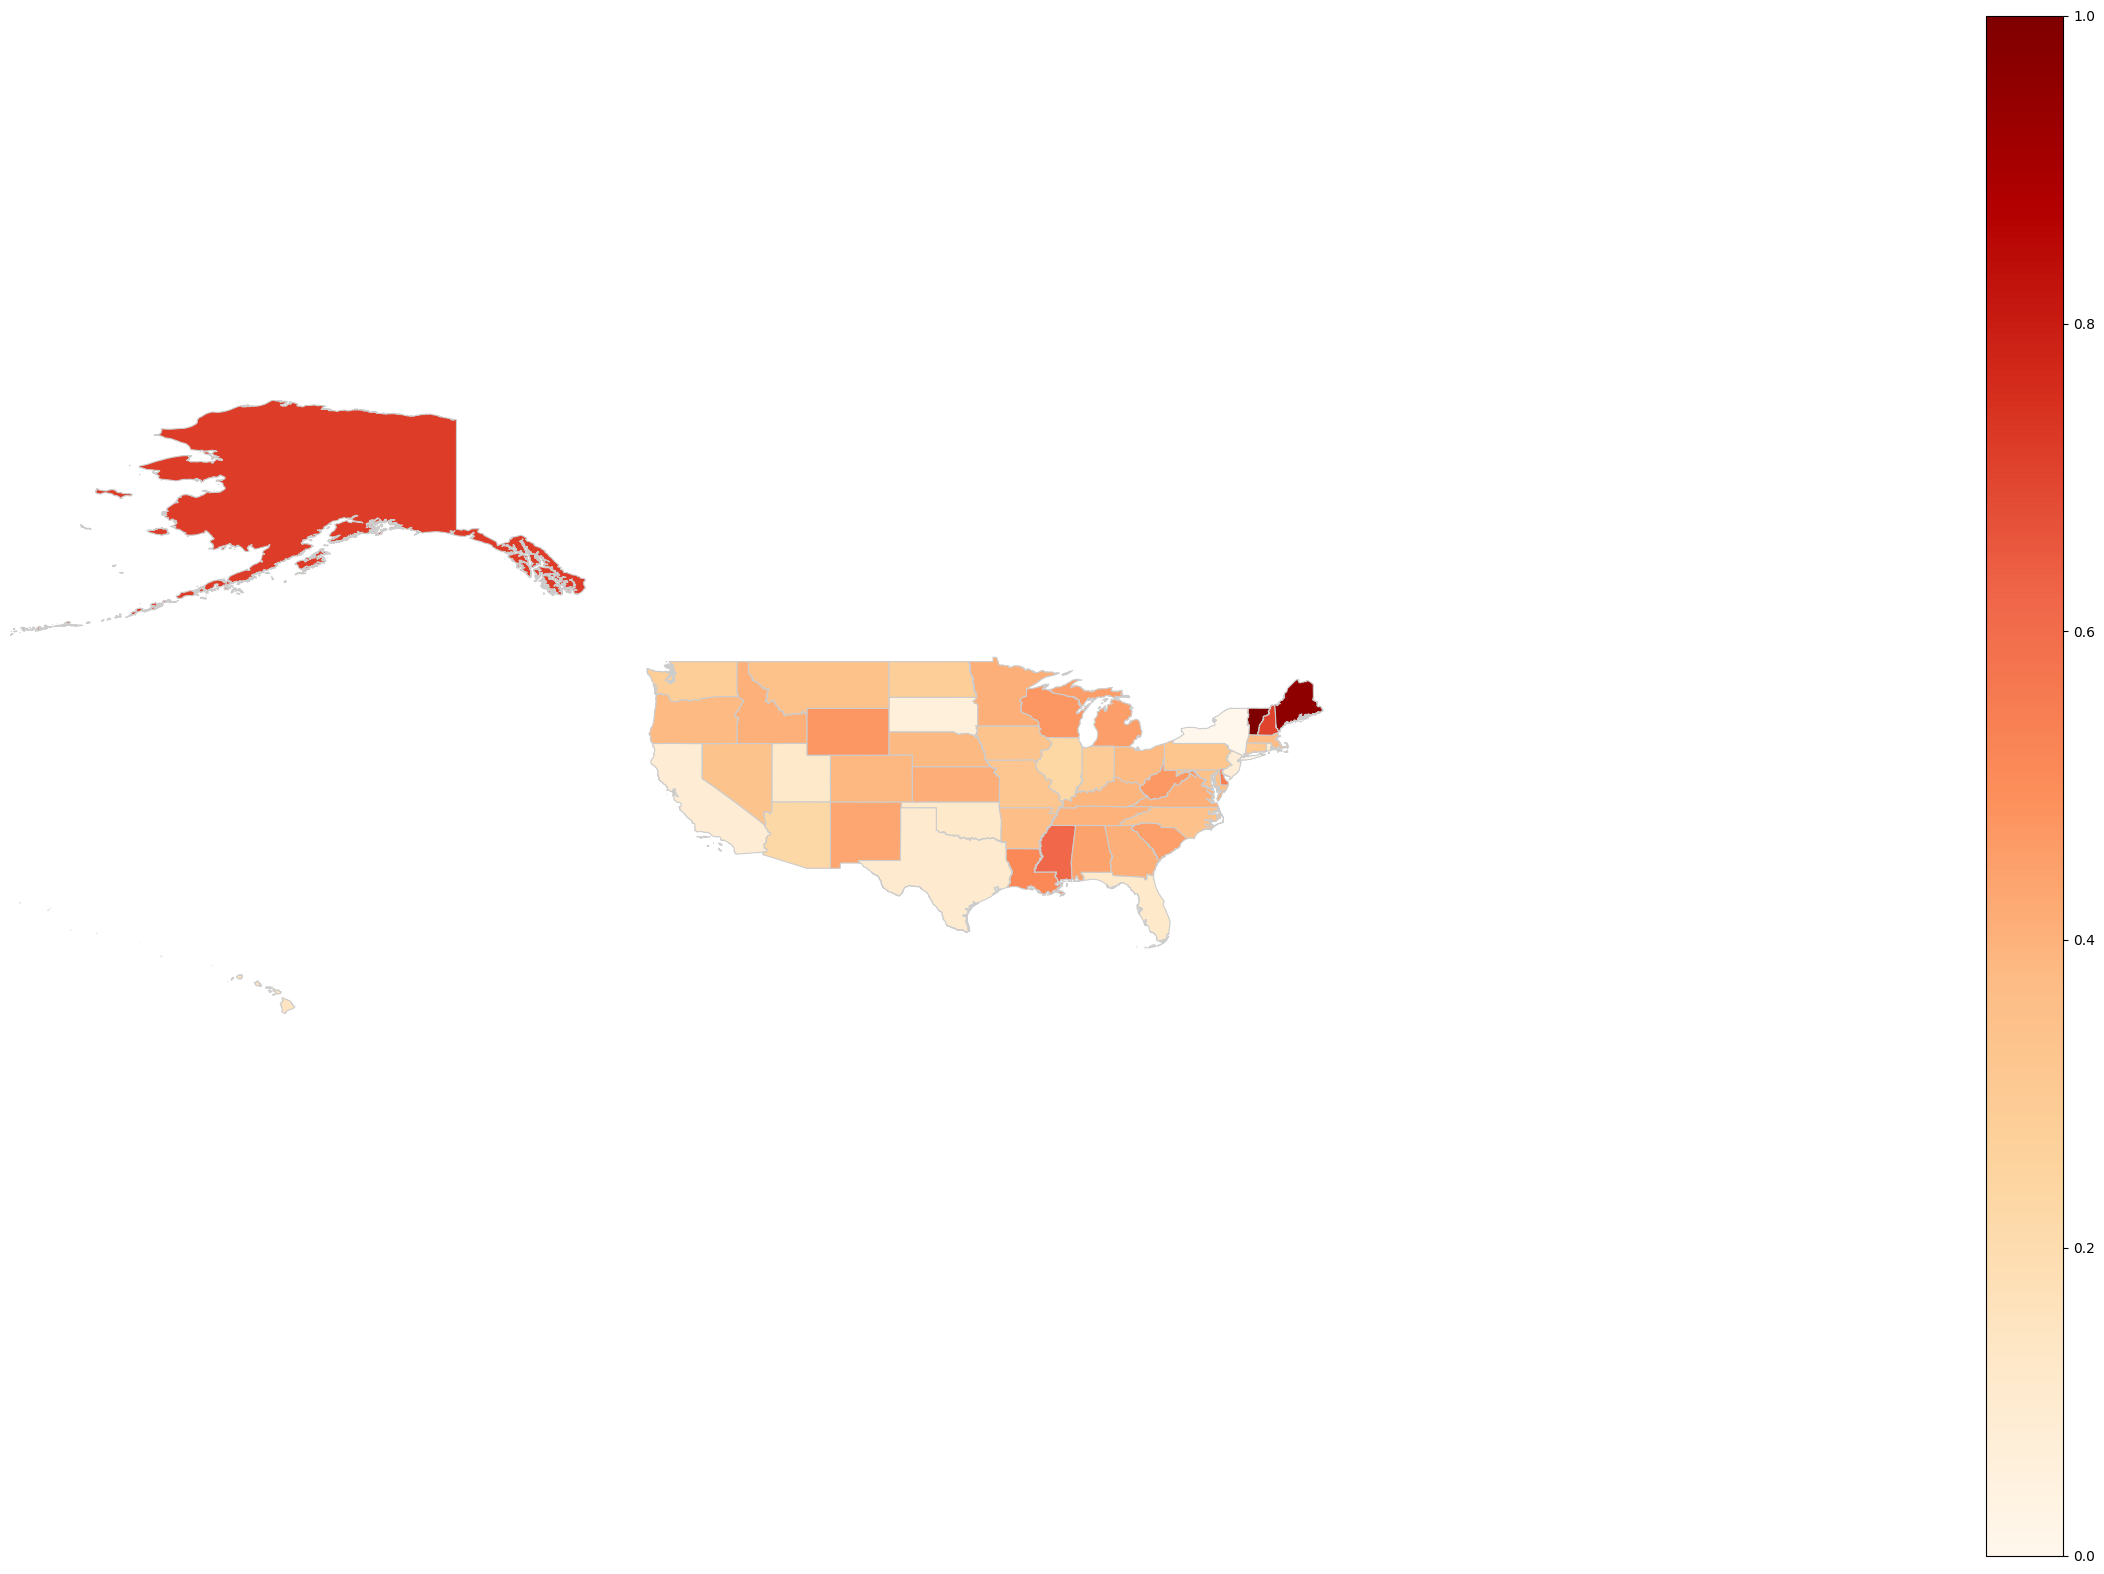

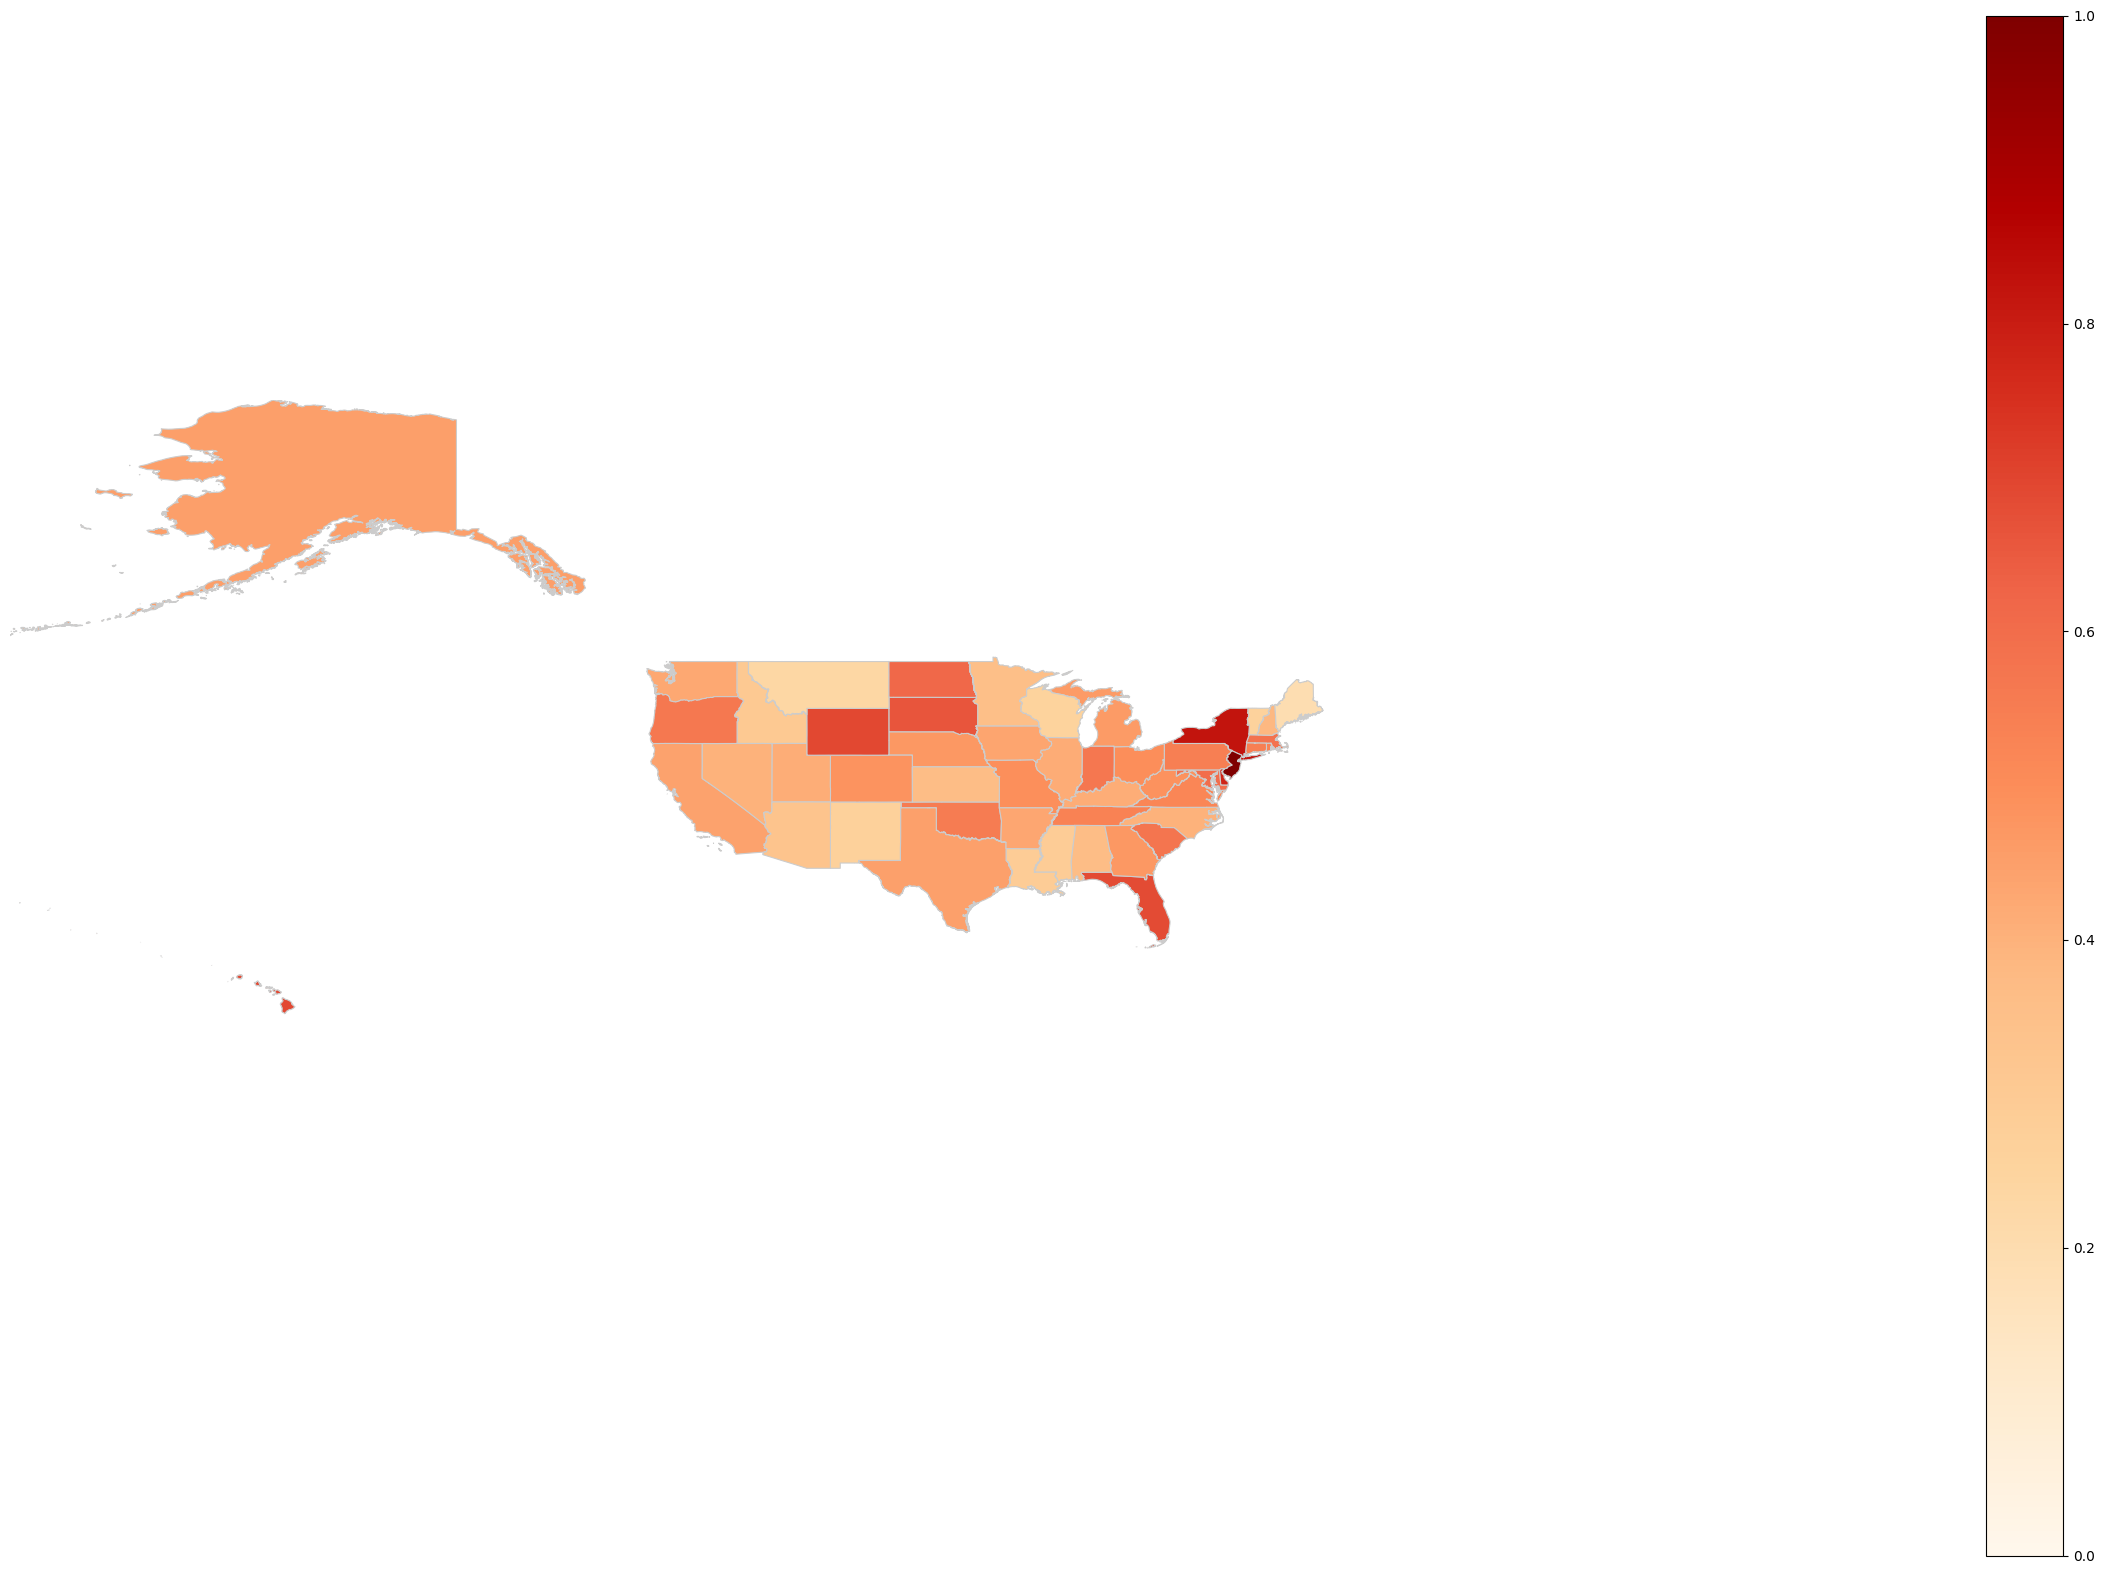

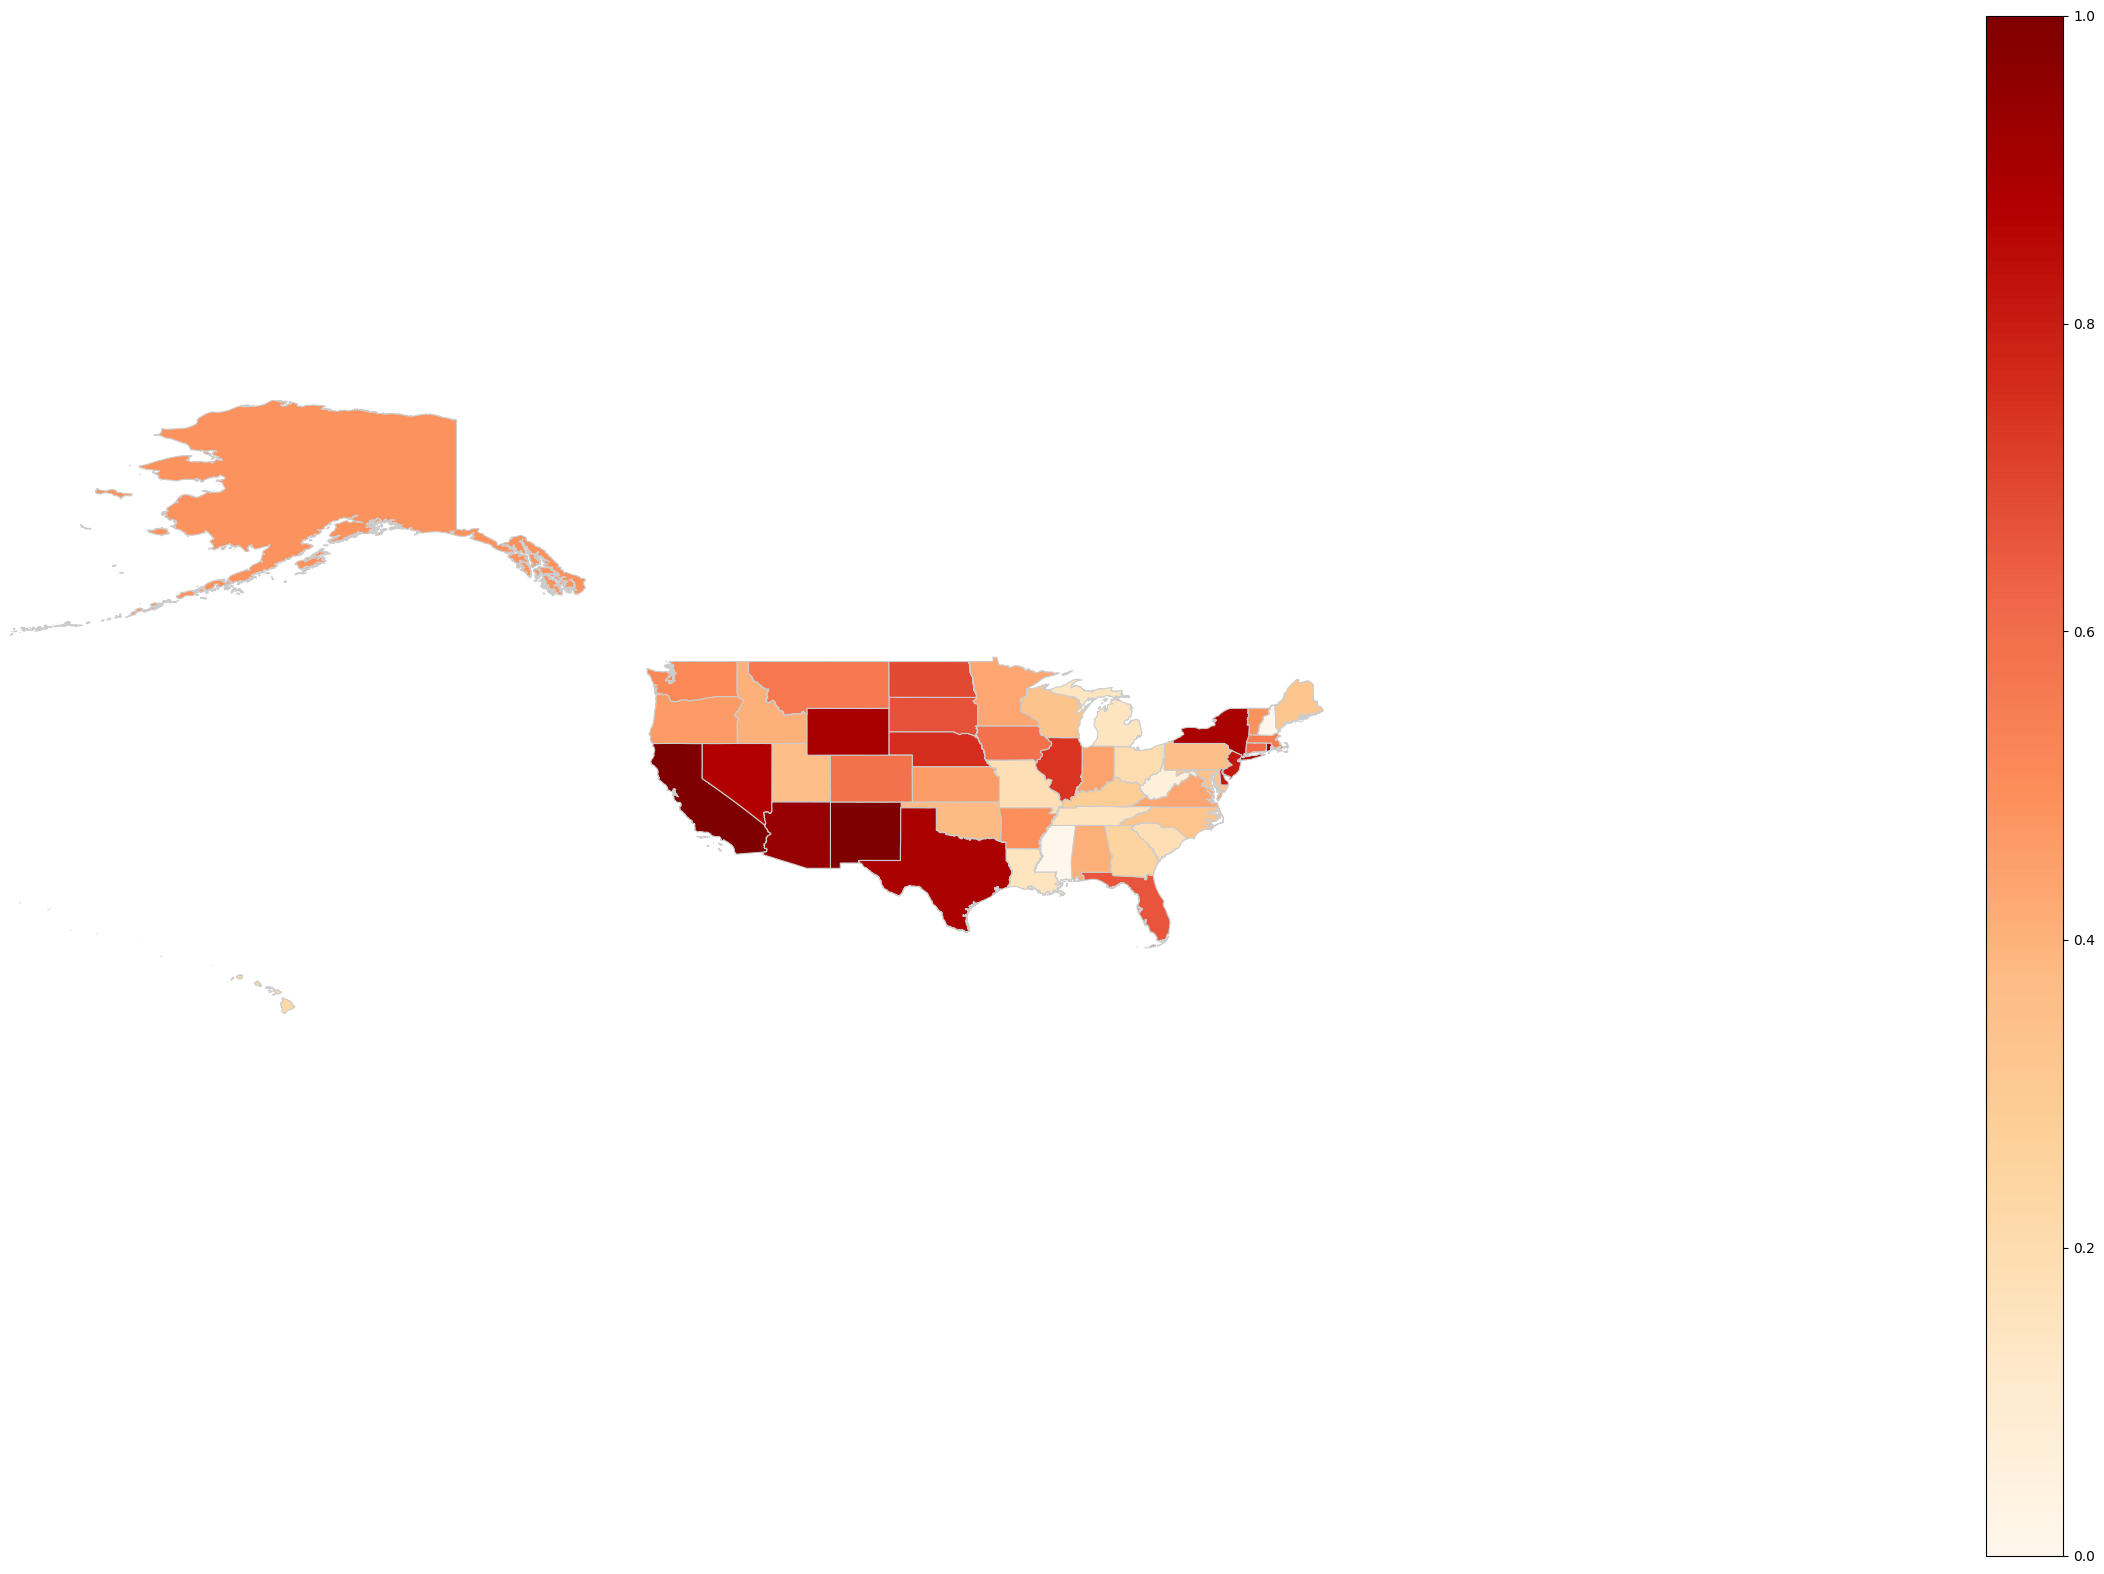

In [107]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

states = list(data.keys())

# state_topic_distributions = {}

# for state, bow in zip(states, corpus):
#     state_topic_distributions[state] = lda.get_document_topics(bow, minimum_probability=0)

# # Print the topic distribution for each state
# for state, distribution in state_topic_distributions.items():
#     print(f"State: {state}, Distribution: {distribution}")


for topic_id in range(sampler.K):
    state_intensity = {state: doc_topic_distributions[doc_id, topic_id] 
                        for doc_id, state in enumerate(states)}
    # Load the shapefile using Geopandas
    
    shapefile_path = "cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
    gdf = gpd.read_file(shapefile_path)

    # Ensure that the GeoDataFrame has a column with state abbreviations that match your distribution keys
    gdf['state_abbr'] = gdf['STUSPS']  # Replace 'STUSPS' with the actual column name for state abbreviations if different

    # Convert the dictionary to a DataFrame
    # print(list(state_intensity.items())[0])
    intensity_df = pd.DataFrame(list([(i[0], i[1]) for i in state_intensity.items()]), columns=['index', 'intensity'])

    # Merge the DataFrame with the GeoDataFrame
    gdf = gdf.merge(intensity_df, how='left', left_on='state_abbr', right_on='index')

    # Set the size of the plot
    fig, ax = plt.subplots(1, 1, figsize=(30, 20))

    # Plot the GeoDataFrame with intensity coloring
    gdf.plot(column='intensity', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

    # Remove the axis
    ax.axis('off')

    # Set the aspect of the plot to equal and adjust the limits if needed
    ax.set_aspect('equal')
    ax.set_xlim([gdf.total_bounds[0], gdf.total_bounds[2] - 200])  # set x limits to the bounds of the shapes
    ax.set_ylim([gdf.total_bounds[1] + 20, gdf.total_bounds[3]])  # set y limits to the bounds of the shapes

    # Add a colorbar
    fig.colorbar(plt.cm.ScalarMappable(cmap='OrRd'), ax=ax)

    # Show the plot
    plt.show()


In [104]:
file_path = 'combined_data.csv'
combined_df = pd.read_csv(file_path)
# columns_to_select = ['state', 'bg', 'pi', 'pl', 'White alone', 'Black or African American alone']
# combined_df = combined_df[columns_to_select]
# print(combined_df)
# columns_to_select = ['state', 'White alone']
# combined_df = combined_df[columns_to_select]
features = combined_df.drop("state", axis=1).values  # Assuming "State" is the state column

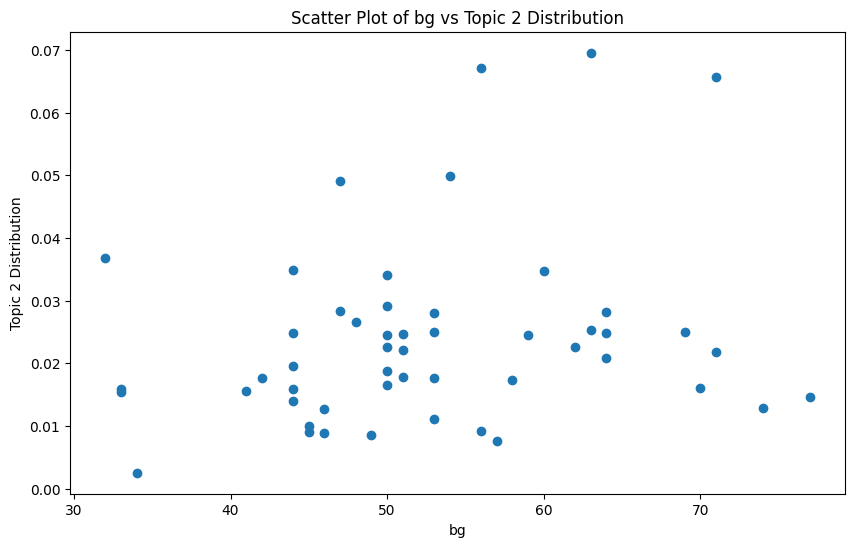

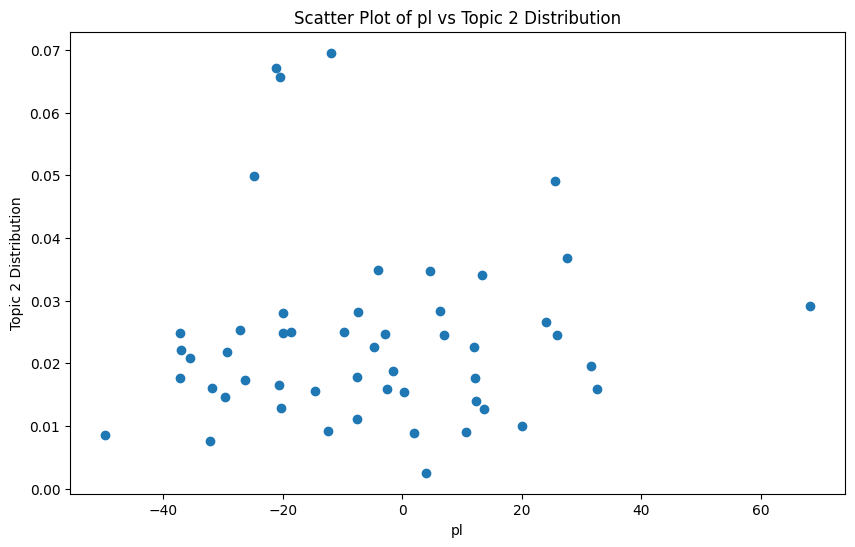

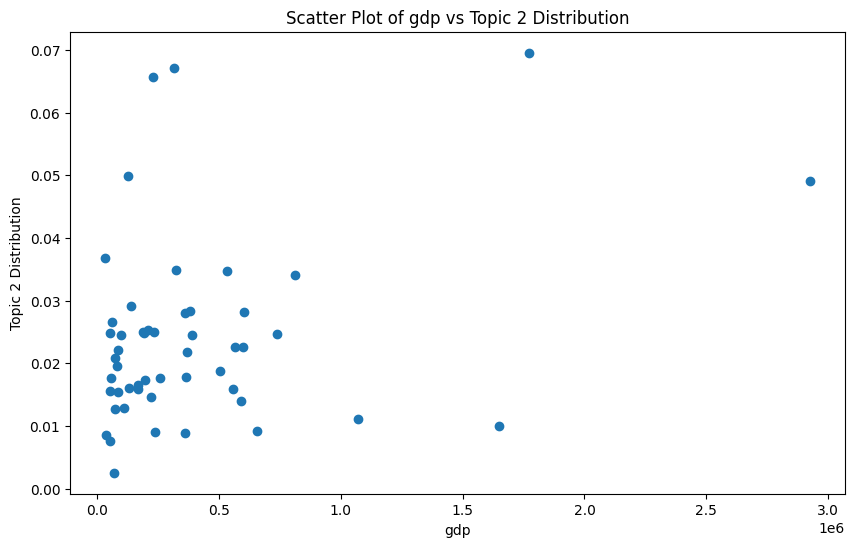

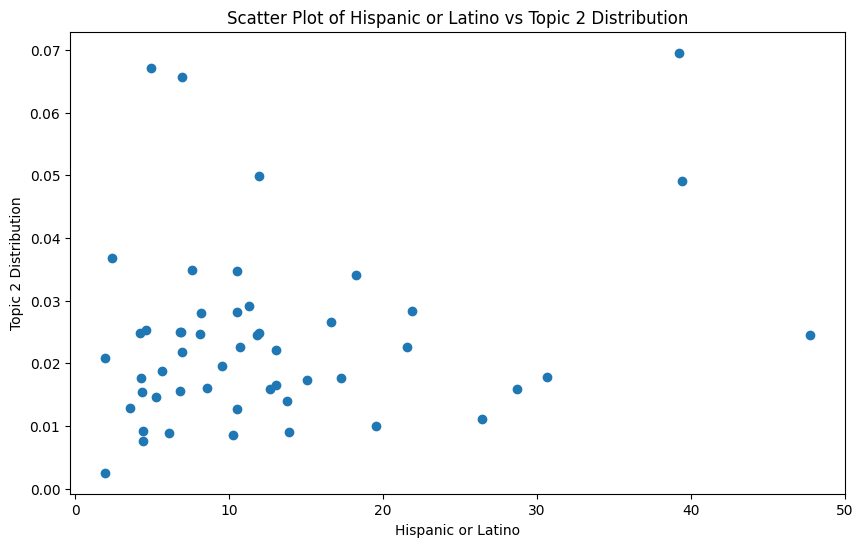

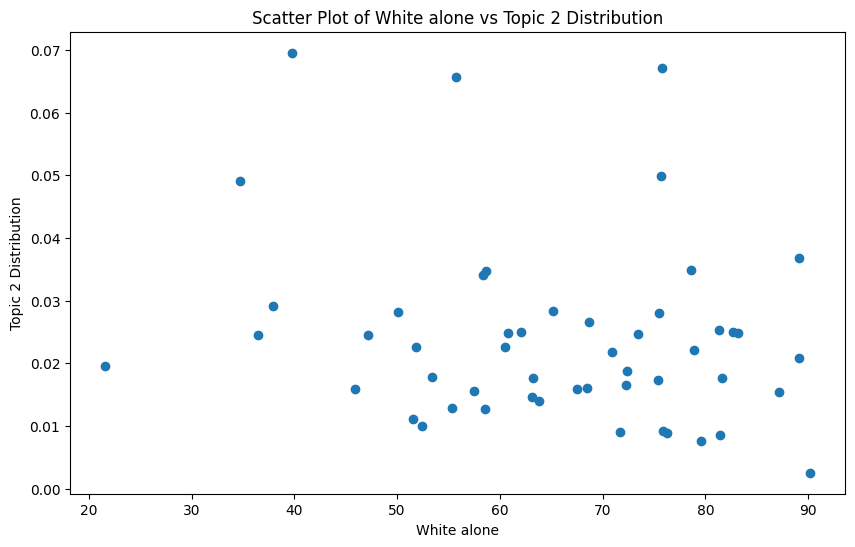

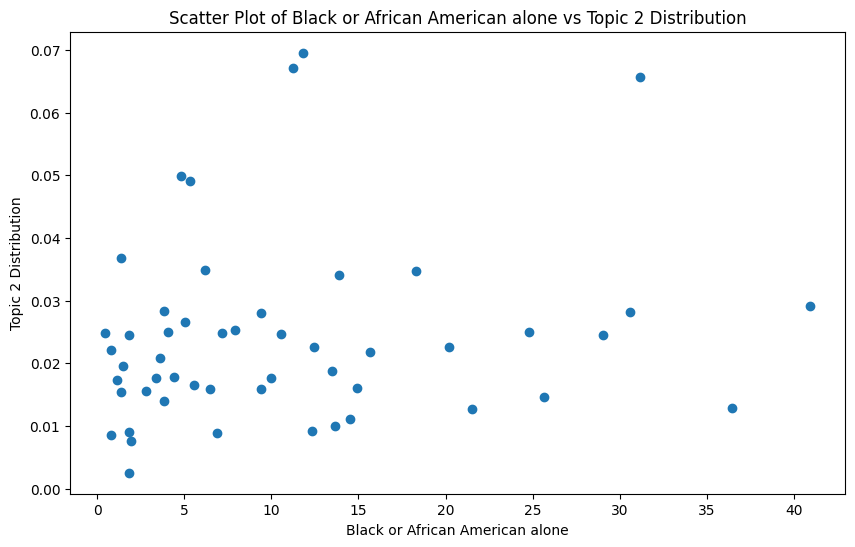

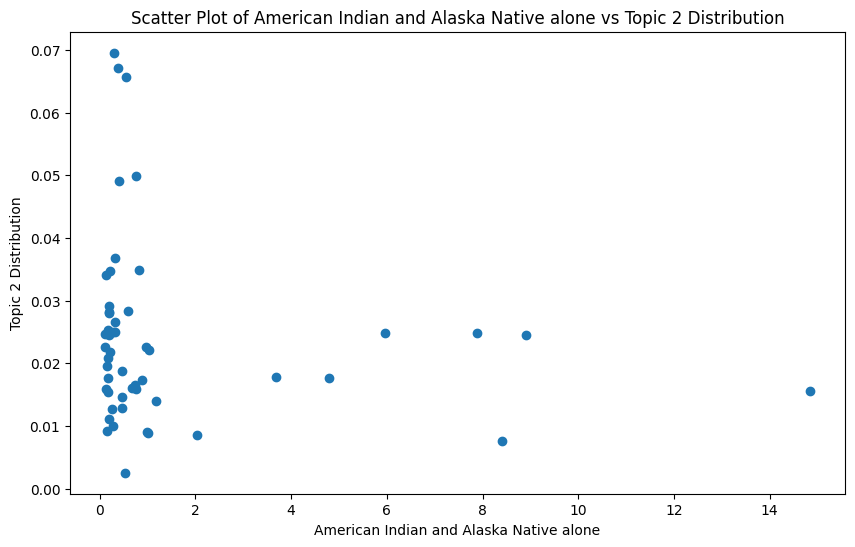

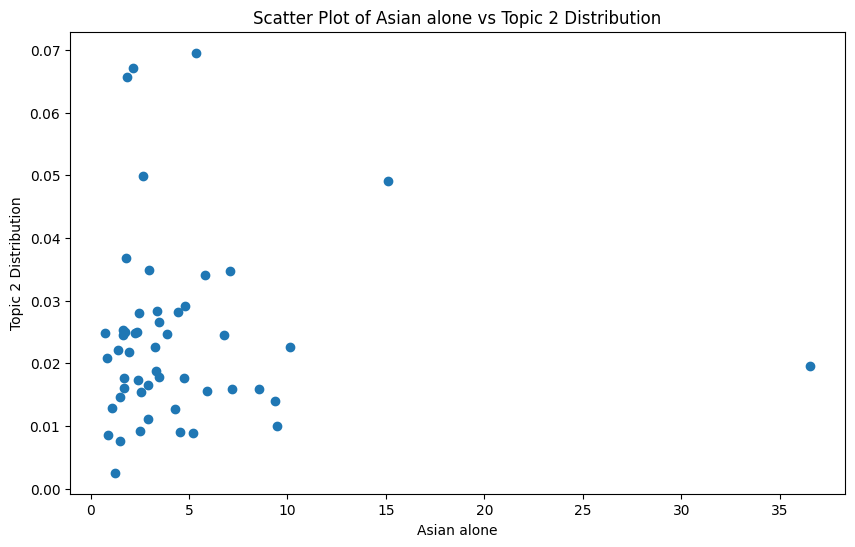

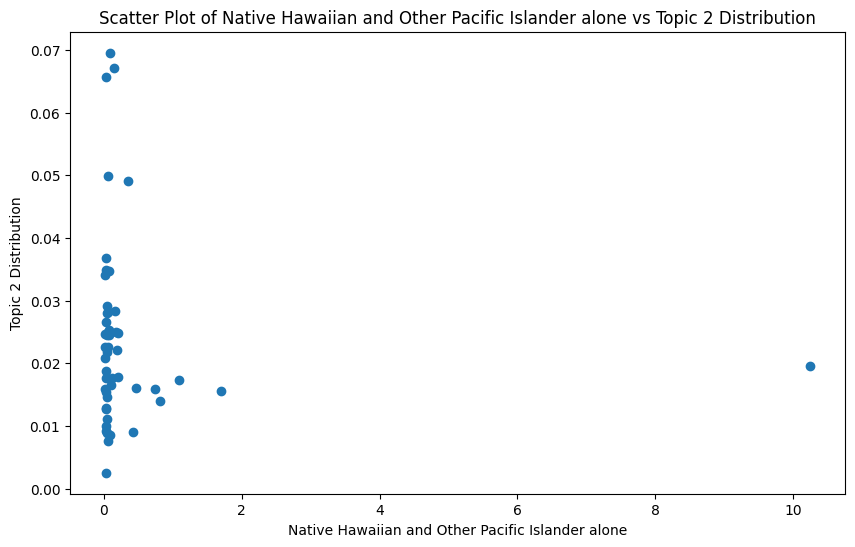

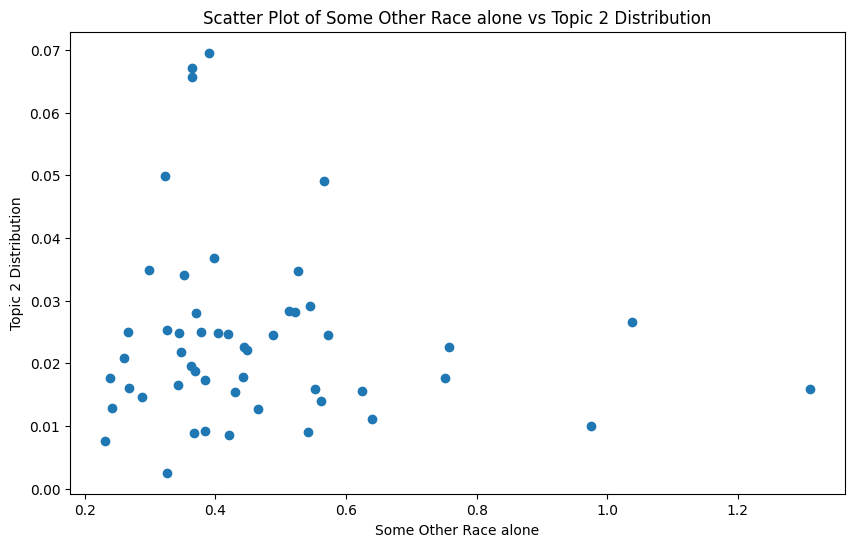

In [106]:
import matplotlib.pyplot as plt
import pandas as pd

# Select a topic
topic_index = 2  # Change this to select a different topic
topic_distribution = doc_topic_distributions[:, topic_index]

# Iterate over each feature column and plot it against the topic distribution
for feature in combined_df.columns:
    if feature != "state":  # Skip the state column
        plt.figure(figsize=(10, 6))
        plt.scatter(combined_df[feature], topic_distribution)
        plt.xlabel(feature)
        plt.ylabel(f"Topic {topic_index} Distribution")
        plt.title(f"Scatter Plot of {feature} vs Topic {topic_index} Distribution")
        plt.show()


In [29]:
from gensim import models
import numpy as np

# Assuming lda is your trained LdaModel and dictionary is your Gensim dictionary

num_topics = lda.num_topics  # Number of topics in the model
topic_word_distributions = {topic: dict(lda.show_topic(topic, topn=len(dictionary))) for topic in range(num_topics)}

# Function to find distinctive words for each topic
def find_distinctive_words(topic_word_distributions):
    distinctive_words = {}
    for topic in topic_word_distributions:
        other_topics = set(topic_word_distributions.keys()) - {topic}
        word_scores = {}

        for word, prob in topic_word_distributions[topic].items():
            max_prob_other_topics = np.max([topic_word_distributions[ot].get(word, 0) for ot in other_topics])
            distinctiveness_score = prob - max_prob_other_topics
            word_scores[word] = distinctiveness_score

        # Sort words by distinctiveness score
        distinctive_words[topic] = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)

    return distinctive_words

# Get distinctive words for each topic
distinctive_words_per_topic = find_distinctive_words(topic_word_distributions)

# Print distinctive words for each topic
for topic, words in distinctive_words_per_topic.items():
    print(f"Topic {topic}:")
    for word, score in words[:20]:  # Adjust the number to get more or fewer words
        print(f"  {word}: {score}")
    print("\n")


Topic 0:
  Benjamin_M: 0.0011674403212964535
  Elizabeth_F: 0.001115197315812111
  Henry_M: 0.000974900322034955
  Bella_F: 0.0009133141720667481
  Joseph_M: 0.0008477226365357637
  Alexander_M: 0.0008449936285614967
  Ryan_M: 0.0007916106842458248
  Sophia_F: 0.0007822304032742977
  Ariana_F: 0.0007795105339027941
  Liam_M: 0.0007745758630335331
  Leo_M: 0.0007533847820013762
  Samuel_M: 0.0007466219831258059
  Isaac_M: 0.0007016626186668873
  Olivia_F: 0.0006529786624014378
  Hannah_F: 0.000650966539978981
  Mila_F: 0.0006440966390073299
  Robert_M: 0.0006149093387648463
  Lyla_F: 0.0005980140995234251
  Zoe_F: 0.0005391015438362956
  Josiah_M: 0.0005294696893543005


Topic 1:
  Mason_M: 0.0018915185937657952
  Oliver_M: 0.001699333544820547
  Asher_M: 0.001469215378165245
  Sebastian_M: 0.001310503575950861
  James_M: 0.0009282708633691072
  Ava_F: 0.0009197341278195381
  William_M: 0.0008991486392915249
  Luna_F: 0.000847772229462862
  Ellie_F: 0.0008439935045316815
  Penelope_F: 0

In [30]:
states = list(data.keys())

state_topic_distributions = {}

for state, bow in zip(states, corpus):
    state_topic_distributions[state] = lda.get_document_topics(bow, minimum_probability=0)

# Print the topic distribution for each state
for state, distribution in state_topic_distributions.items():
    print(f"State: {state}, Distribution: {distribution}")


State: ID, Distribution: [(0, 0.13519719), (1, 0.86480284)]
State: DC, Distribution: [(0, 0.37826875), (1, 0.6217312)]
State: KY, Distribution: [(0, 0.27198446), (1, 0.7280156)]
State: DE, Distribution: [(0, 0.28258607), (1, 0.7174139)]
State: FL, Distribution: [(0, 0.63255423), (1, 0.3674458)]
State: PA, Distribution: [(0, 0.3403776), (1, 0.65962243)]
State: RI, Distribution: [(0, 0.2981932), (1, 0.70180684)]
State: IA, Distribution: [(0, 0.15327822), (1, 0.8467218)]
State: WA, Distribution: [(0, 0.36495242), (1, 0.63504755)]
State: WV, Distribution: [(0, 0.17583188), (1, 0.8241681)]
State: NC, Distribution: [(0, 0.4026934), (1, 0.59730655)]
State: MO, Distribution: [(0, 0.20080931), (1, 0.7991907)]
State: AL, Distribution: [(0, 0.34149832), (1, 0.65850174)]
State: AZ, Distribution: [(0, 0.45414165), (1, 0.5458583)]
State: MN, Distribution: [(0, 0.24951561), (1, 0.7504844)]
State: TN, Distribution: [(0, 0.32258767), (1, 0.6774124)]
State: OR, Distribution: [(0, 0.2508707), (1, 0.74912

In [19]:
! python3 -m pip install geopandas

  Obtaining dependency information for geopandas from https://files.pythonhosted.org/packages/3e/cf/ede993ed7070c5487e6db550aad490178c06eaa48ad26ff5e5263f995fba/geopandas-0.14.1-py3-none-any.whl.metadata
  Obtaining dependency information for fiona>=1.8.21 from https://files.pythonhosted.org/packages/b7/28/6e793b91b60b817646780ed9805a81456bd9b99ecd640306b1bf96819778/fiona-1.9.5-cp312-cp312-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.6 MB/s eta 0:00:00
  Obtaining dependency information for pyproj>=3.3.0 from https://files.pythonhosted.org/packages/10/f2/b550b1f65cc7e51c9116b220b50aade60c439103432a3fd5b12efbc77e15/pyproj-3.6.1-cp312-cp312-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for shapely>=1.8.0 from https://files.pythonhosted.org/packages/5c/d9/d557c09d15406aad8252caeae181c2db2c562cc1b2ca6e6482b43274b25f/shapely-2.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/6

DriverError: /Users/hanmingyang/Downloads/cb_2018_us_state_500k/cb_2018_us_state_500k.shp: No such file or directory

In [32]:
file_path = 'combined_data.csv'
combined_df = pd.read_csv(file_path)
# columns_to_select = ['state', 'bg', 'pi', 'pl', 'White alone', 'Black or African American alone']
# combined_df = combined_df[columns_to_select]
# print(combined_df)
# columns_to_select = ['state', 'White alone']
# combined_df = combined_df[columns_to_select]
features = combined_df.drop("state", axis=1).values  # Assuming "State" is the state column

In [33]:
# Adjusted state_topic_mapping to include all topic probabilities
state_topic_mapping = {}
for state, distribution in state_topic_distributions.items():
    state_topic_mapping[state] = [prob[1] for prob in distribution]  # Retrieves probabilities for all topics

# Extract the aligned topic proportions for all topics as labels based on `combined_df` order
labels = np.array([state_topic_mapping[state] for state in combined_df["state"]])
features = combined_df.drop("state", axis=1).values  # Assuming "State" is the state column

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features to normalize them
features_normalized = scaler.fit_transform(features)
# Initialize the Linear Regression model
model = LinearRegression()



# Fit the model with the normalized features and the aligned topic distributions
model.fit(features_normalized, labels)


LinearRegression()

In [34]:
# Make predictions using the model
predictions = model.predict(features_normalized)

# Calculating R-squared for each topic
r_squared_values = [r2_score(labels[:, i], predictions[:, i]) for i in range(predictions.shape[1])]

# Print R-squared for each topic
for i, r_squared in enumerate(r_squared_values):
    print(f"R-squared for Topic {i}: {r_squared}")

# Coefficients for each topic
# model.coef_ will have a shape of (n_topics, n_features)
coefficients = model.coef_

# Print coefficients for each topic
feature_names = combined_df.columns.drop("state")  # Assuming "State" is the state column
for i, topic_coefficients in enumerate(coefficients):
    print(f"Coefficients for Topic {i}:")
    for feature_name, coefficient in zip(feature_names, topic_coefficients):
        print(f"  {feature_name}: {coefficient}")


R-squared for Topic 0: 0.8727262363477346
R-squared for Topic 1: 0.8727262719157703
Coefficients for Topic 0:
  bg: 0.019903402293805737
  pl: -0.0029182974026925592
  gdp: 0.02727978742044138
  Hispanic or Latino: 0.09648943734306614
  White alone: 0.04754833605889907
  Black or African American alone: 0.08476454853784636
  American Indian and Alaska Native alone: -0.00303165963731911
  Asian alone: 0.0696483712486738
  Native Hawaiian and Other Pacific Islander alone: -0.009790135361639626
  Some Other Race alone: 0.030561924385925025
Coefficients for Topic 1:
  bg: -0.019903405410697284
  pl: 0.0029182958997175847
  gdp: -0.02727978751153439
  Hispanic or Latino: -0.09648943986337333
  White alone: -0.04754832391795911
  Black or African American alone: -0.08476454521175186
  American Indian and Alaska Native alone: 0.003031662327145131
  Asian alone: -0.06964837432537384
  Native Hawaiian and Other Pacific Islander alone: 0.009790144241065064
  Some Other Race alone: -0.03056191902

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np

# Assuming you have already created and populated the `state_topic_distributions` dictionary
# and you have the `combined_df` DataFrame with state-related columns as features

# Choose the topic you want to use as labels
chosen_topic =1  # Replace with the index of the desired topic

# Create a mapping of state names to topic distributions
state_topic_mapping = {}
for state, distribution in state_topic_distributions.items():
    state_topic_mapping[state] = distribution[chosen_topic][1]  # [1] retrieves the probability for the chosen topic

# Extract the aligned topic proportions as labels based on `combined_df` order
labels = [state_topic_mapping[state] for state in combined_df["state"]]
features = combined_df.drop("state", axis=1).values  # Assuming "State" is the state column

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features to normalize them
features_normalized = scaler.fit_transform(features)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model with the normalized features
model.fit(features_normalized, labels)

# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Make predictions using the model
predictions = model.predict(features_normalized)

# Calculate R-squared
r_squared = r2_score(labels, predictions)

print("R-squared:", r_squared)

# Print coefficients and feature names
feature_names = combined_df.columns[1:]  # Exclude the "State" column
for feature_name, coefficient in zip(feature_names, coefficients):
    print(f"{feature_name}: {coefficient}")


R-squared: 0.8727262719157703
bg: -0.019903405410697284
pl: 0.0029182958997175847
gdp: -0.02727978751153439
Hispanic or Latino: -0.09648943986337333
White alone: -0.04754832391795911
Black or African American alone: -0.08476454521175186
American Indian and Alaska Native alone: 0.003031662327145131
Asian alone: -0.06964837432537384
Native Hawaiian and Other Pacific Islander alone: 0.009790144241065064
Some Other Race alone: -0.030561919026646726
